In [1]:
%reload_ext autoreload
%autoreload 2

import sys

import numpy as np
import healpy as hp
import jax.numpy as jnp
from jax import jit, vmap
    
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
import matplotlib.gridspec as gridspec
mpl.rc_file('../matplotlibrc')

In [2]:
sys.path.append("..")
from axionmirror.gsr import B_JF, n_e_SRWE, spec_ind_alpha
from axionmirror.nfw import intg_d_s
from axionmirror.geometry import GCstz, cross_product, vstz2vxyz_stz, LOS_direction, GCxyz_stz, unit_vec, Glbd

## Combined

In [55]:
# (c)
B_func = B_JF
n_e_func = n_e_SRWE
    
def power_density(stz):
    """Synchrotron intensity taking into account the direction of the B field.
    p [unnormalized] as a function of stz ([kpc], [rad], [kpc]). Vectorized manually;
    batch dimension is the first.
    """
    B_vxyz = vstz2vxyz_stz(B_func(stz), stz)
    LOS_vxyz = LOS_direction(GCxyz_stz(stz))
    B_perp_vxyz = jnp.linalg.norm(cross_product(B_vxyz, LOS_vxyz), axis=-1)
    return n_e_func(stz) * B_perp_vxyz**spec_ind_alpha

@jit
@vmap
def I_src(lb):
    l, b = lb
    lbd = jnp.stack([jnp.full_like(intg_d_s, l),
                     jnp.full_like(intg_d_s, b),
                     intg_d_s], axis=-1)
    I_integrands = power_density(GCstz(lbd))
    return jnp.trapz(I_integrands, intg_d_s)

nside = 256
l, b = hp.pixelfunc.pix2ang(nside, np.arange(hp.nside2npix(nside)), lonlat=True)
l = jnp.deg2rad(l)
b = jnp.deg2rad(b)
I_map = I_src(jnp.stack([l, b], axis=-1))

# (d)
haslam_dsds_map_hp = hp.read_map('../data/gsr/haslam408_dsds_Remazeilles2014.fits')

# (e)
I_map_512 = hp.ud_grade(I_map, nside_out=512)
I_map_plot = np.array(I_map_512) / np.mean(np.clip(I_map_512, None, 100.)) * np.mean(haslam_dsds_map_hp)

# (f)
li_s = np.linspace(0, 360, 100)
bi_s = np.linspace(-90, 90, 100)
li_grid, bi_grid = jnp.meshgrid(li_s, bi_s)
ratio_map_hp = haslam_dsds_map_hp/np.array(I_map_plot)
ratio_map_grid = jnp.array(hp.pixelfunc.get_interp_val(ratio_map_hp, li_grid, bi_grid, lonlat=True))

def interp2d(f, x0, x1, xv):
    """Interpolates f(x) at values in xvs. Does not do bound checks.
    f : (n>=2 D) array of function value.
    x0 : 1D array of input value, corresponding to first dimension of f.
    x1 : 1D array of input value, corresponding to second dimension of f.
    xv : [x0, x1] values to interpolate.
    """
    xv0, xv1 = xv
    
    li0 = jnp.searchsorted(x0, xv0) - 1
    lx0 = x0[li0]
    rx0 = x0[li0+1]
    p0 = (xv0-lx0) / (rx0-lx0)
    
    li1 = jnp.searchsorted(x1, xv1) - 1
    lx1 = x1[li1]
    rx1 = x1[li1+1]
    p1 = (xv1-lx1) / (rx1-lx1)
    
    fll = f[li0,li1]
    return fll + (f[li0+1,li1]-fll)*p0 + (f[li0,li1+1]-fll)*p1

interp2d_vmap = jit(vmap(interp2d, in_axes=(None, None, None, 0)))

def ratio(stz):
    lbd = Glbd(stz)
    lb = lbd[:, :2]
    return interp2d_vmap(ratio_map_grid, bi_s, li_s, lb)

view_sz = jnp.array([40, 20]) # assume t = PI

def Vstz(lbd):
    """stz from viewer's lbd."""
    vs, vz = view_sz
    v_GC_d = jnp.sqrt(vs**2 + vz**2)
    l, b, d = lbd[:,0], lbd[:,1], lbd[:,2]
    rx = d * jnp.cos(b) * jnp.cos(l) - v_GC_d # rotated x
    ry = d * jnp.cos(b) * jnp.sin(l) # rotated y = original y
    rz = d * jnp.sin(b) # rotated z

    r_angle = jnp.arctan(vz/vs)
    x = rx * jnp.cos(r_angle) + rz * jnp.sin(r_angle)
    y = ry
    z = - rx * jnp.sin(r_angle) + rz * jnp.cos(r_angle)
    
    return jnp.stack([jnp.sqrt(x**2 + y**2),
                      jnp.arctan2(y, x),
                      z], axis=-1)

def VLOS_direction(xyz):
    """Viewer's line of sight direction (radially outward) of xyz coordinates."""
    x, y, z = xyz[:,0], xyz[:,1], xyz[:,2]
    vs, vz = view_sz
    return unit_vec(jnp.stack([x+vs, y, z-vz], axis=-1))

def Vpd(stz):
    B_vxyz = vstz2vxyz_stz(B_func(stz), stz)
    VLOS_vxyz = VLOS_direction(GCxyz_stz(stz))
    B_perp_vxyz = jnp.linalg.norm(cross_product(B_vxyz, VLOS_vxyz), axis=-1)
    return n_e_func(stz) * B_perp_vxyz**spec_ind_alpha * ratio(stz)
    
@jit
@vmap
def VI(lb):
    l, b = lb
    lbd = jnp.stack([jnp.full_like(intg_d_s, l),
                     jnp.full_like(intg_d_s, b),
                     intg_d_s], axis=-1)
    I_integrands = Vpd(Vstz(lbd))
    return jnp.trapz(I_integrands, intg_d_s)

npix = 300
l_s = np.deg2rad(np.linspace(-50, 50, npix))
b_s = np.deg2rad(np.linspace(-30, 21.666, npix))
l_grid, b_grid = jnp.meshgrid(l_s, b_s)
lb_flat = jnp.stack([l_grid.ravel(), b_grid.ravel()], axis=-1)
VI_map = VI(lb_flat).reshape((npix, npix))

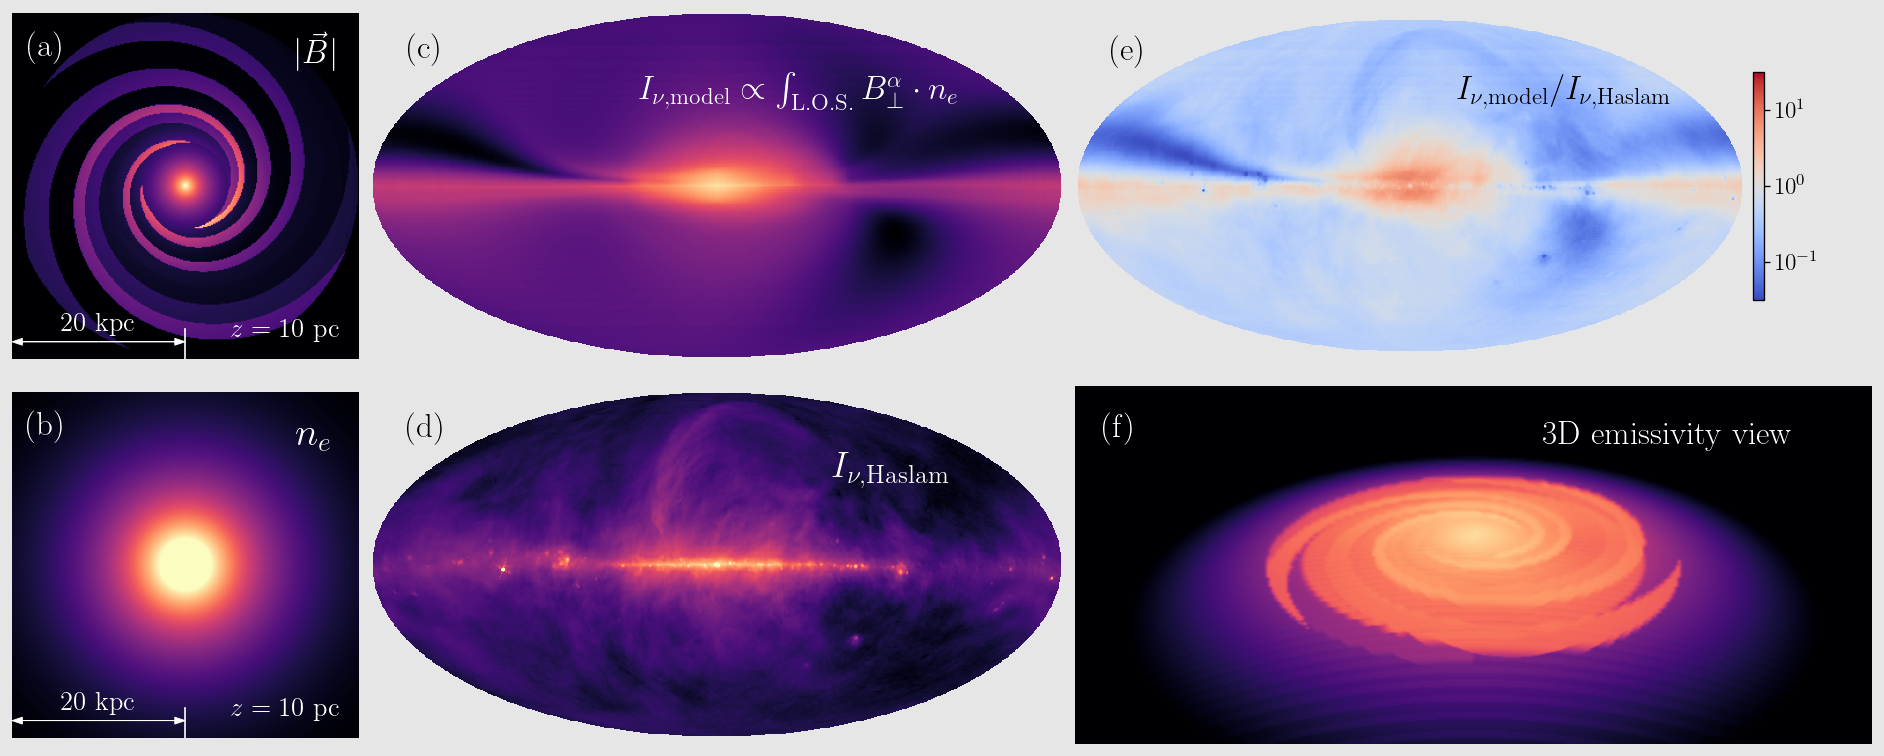

In [64]:
fig = plt.figure(figsize=(20, 8.2))
gs = mpl.gridspec.GridSpec(nrows=2, ncols=3, wspace=0.02, hspace=0., width_ratios=[1, 2, 2.3])

show_str = 'abcdef'

bgcolor = cms['binary'](0.1)

if 'a' in show_str:
    ax = fig.add_subplot(gs[0, 0])

    func = lambda x: jnp.linalg.norm(B_JF(x), axis=-1)
    smax = 20 # [kpc]
    h_zval = 0.01 # [kpc]
    npix = 300
        
    x_s = jnp.linspace(-smax, smax, npix)
    y_s = jnp.linspace(-smax, smax, npix)
    x_ss, y_ss = jnp.meshgrid(x_s, y_s)

    x_in = jnp.reshape(x_ss, (npix*npix,))
    y_in = jnp.reshape(y_ss, (npix*npix,))
    stz_in = jnp.stack([jnp.sqrt(x_in**2+y_in**2), jnp.arctan2(y_in, x_in), jnp.full_like(x_in, h_zval)], axis=-1)
    hslice = jnp.reshape(func(stz_in), (npix, npix))

    vmax = jnp.max(hslice[hslice<jnp.inf])
    vmin = jnp.min(hslice[hslice<jnp.inf])
    im = ax.imshow(jnp.flipud(hslice), extent=(-smax, smax, -smax, smax), cmap='magma')
    ax.text(18, 18, r'$|\vec B|$', color='w', fontsize=20, ha='right', va='top')
    ax.text(18, -18, r'$z=10~$pc', color='w', fontsize=16, ha='right', va='bottom')
    ax.axis('off')
    ax.arrow(-10, -18, 10,  0, fc='w', ec='w', length_includes_head=True, head_width=0.8, lw=0.5)
    ax.arrow(-10, -18, -10, 0, fc='w', ec='w', length_includes_head=True, head_width=0.8, lw=0.5)
    ax.plot([0, 0], [-20, -16.5], color='w', lw=1)
    ax.text(-10, -16, '20 kpc', color='w', ha='center', va='center', fontsize=16)
    ax.text(0.1, 0.9, '(a)', color='w', fontsize=20, ha='center', va='center', transform=ax.transAxes)

if 'b' in show_str:
    ax = fig.add_subplot(gs[1, 0])

    func = n_e_SRWE
    smax = 20 # [kpc]
    h_zval = 0.01 # [kpc]
    npix = 300
        
    x_s = jnp.linspace(-smax, smax, npix)
    y_s = jnp.linspace(-smax, smax, npix)
    x_ss, y_ss = jnp.meshgrid(x_s, y_s)

    x_in = jnp.reshape(x_ss, (npix*npix,))
    y_in = jnp.reshape(y_ss, (npix*npix,))
    stz_in = jnp.stack([jnp.sqrt(x_in**2+y_in**2), jnp.arctan2(y_in, x_in), jnp.full_like(x_in, h_zval)], axis=-1)
    hslice = jnp.reshape(func(stz_in), (npix, npix))

    vmax = jnp.max(hslice[hslice<jnp.inf])
    vmin = jnp.min(hslice[hslice<jnp.inf])
    im = ax.imshow(jnp.flipud(hslice), extent=(-smax, smax, -smax, smax), cmap='magma')
    ax.text(17, 17, r'$n_e$', color='w', fontsize=24, ha='right', va='top')
    ax.text(18, -18, r'$z=10~$pc', color='w', fontsize=16, ha='right', va='bottom')
    ax.axis('off')
    ax.arrow(-10, -18, 10,  0, fc='w', ec='w', length_includes_head=True, head_width=0.8, lw=0.5)
    ax.arrow(-10, -18, -10, 0, fc='w', ec='w', length_includes_head=True, head_width=0.8, lw=0.5)
    ax.plot([0, 0], [-20, -16.5], color='w', lw=1)
    ax.text(-10, -16, '20 kpc', color='w', ha='center', va='center', fontsize=16)
    ax.text(0.1, 0.9, '(b)', color='w', fontsize=20, ha='center', va='center', transform=ax.transAxes)

if 'c' in show_str:
    ax = fig.add_subplot(gs[0, 1])

    plt.sca(ax)
    #plt.gca().patch.set_facecolor('lightgray')
    hp.mollview(I_map, cmap='magma', hold=True, norm='log', title='', cbar=False, max=200, bgcolor=bgcolor)
    fig.text(0.85, 0.75, r'$I_{\nu,\mathrm{model}}\propto \int_\mathrm{L.O.S.} B_\perp^\alpha\cdot n_e$', color='w', fontsize=20, ha='right', va='center', transform=ax.transAxes)
    fig.text(0.08, 0.86, '(c)', color='k', fontsize=20, ha='center', va='center', transform=ax.transAxes)

if 'd' in show_str:
    ax = fig.add_subplot(gs[1, 1])

    plt.sca(ax)
    #plt.gca().patch.set_facecolor('lightgray')
    hp.mollview(haslam_dsds_map_hp, cmap='magma', hold=True, norm='log', title='', cbar=False, max=30*np.median(haslam_dsds_map_hp), bgcolor=bgcolor)
    fig.text(0.75, 0.75, r'$I_{\nu,\mathrm{Haslam}}$', color='w', fontsize=22, ha='center', va='center', transform=ax.transAxes)
    fig.text(0.08, 0.86, '(d)', color='k', fontsize=20, ha='center', va='center', transform=ax.transAxes)

if 'e' in show_str:
    ax = fig.add_subplot(gs[0, 2])

    plt.sca(ax)
    
    hp.mollview(-np.log10(haslam_dsds_map_hp/np.array(I_map_plot)), cmap='coolwarm', hold=True, title='', cbar=False, min=-1.5, max=1.5, bgcolor=bgcolor)
    fig.text(0.75, 0.75, r'$I_{\nu,\mathrm{model}}/I_{\nu,\mathrm{Haslam}}$', color='k', fontsize=20,
            transform=ax.transAxes, ha='right', va='center')
    ax = plt.gca()
    image = ax.get_images()[0]
    cbar = fig.colorbar(image, ax=ax, orientation='vertical', aspect=20, pad=0.01, ticks=[-1, 0, 1], shrink=0.6)
    cbar.ax.set_yticklabels([r'$10^{-1}$', r'$10^0$', r'$10^{1}$'])
    fig.text(0.08, 0.9, '(e)', color='k', fontsize=20, ha='center', va='center', transform=ax.transAxes)

if 'f' in show_str:
    ax = fig.add_subplot(gs[1, 2])

    ax.imshow(np.flip(np.log10(np.clip(VI_map, 1e-10, None))), cmap='magma', extent=(-50, 50, -25, 20),
          interpolation='bicubic', vmax=2, vmin=-10)
    ax.axis('off')
    ax.text(0.9, 0.9, '3D emissivity view', color='w', transform=ax.transAxes,
            ha='right', va='top', fontsize=20)
    ax.text(0.055, 0.88, '(f)', color='w', fontsize=20, ha='center', va='center', transform=ax.transAxes)

plt.gcf().patch.set_facecolor(bgcolor)

if show_str == 'abcdef':
    plt.savefig('plots/gsr.pdf', bbox_inches='tight')

### 1. $B$

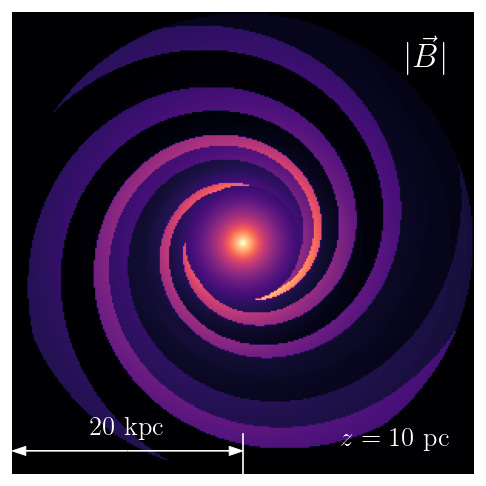

In [3]:
fig, ax = plt.subplots(figsize=(5, 5))

func = lambda x: jnp.linalg.norm(B_JF(x), axis=-1)
smax = 20 # [kpc]
h_zval = 0.01 # [kpc]
npix = 300
    
x_s = jnp.linspace(-smax, smax, npix)
y_s = jnp.linspace(-smax, smax, npix)
x_ss, y_ss = jnp.meshgrid(x_s, y_s)

x_in = jnp.reshape(x_ss, (npix*npix,))
y_in = jnp.reshape(y_ss, (npix*npix,))
stz_in = jnp.stack([jnp.sqrt(x_in**2+y_in**2),
                    jnp.arctan2(y_in, x_in),
                    jnp.full_like(x_in, h_zval)], axis=-1)
hslice = jnp.reshape(func(stz_in), (npix, npix))

vmax = jnp.max(hslice[hslice<jnp.inf])
vmin = jnp.min(hslice[hslice<jnp.inf])
im = ax.imshow(jnp.flipud(hslice), extent=(-smax, smax, -smax, smax), cmap='magma')
ax.text(18, 18, r'$|\vec B|$', color='w', fontsize=20, ha='right', va='top')
ax.text(18, -18, r'$z=10~$pc', color='w', fontsize=16, ha='right', va='bottom')
ax.axis('off')
#ax.set_xticks([-20, -10, 0, 10, 20])
#ax.set_yticks([-20, -10, 0, 10, 20])
#ax.set(xlabel='[kpc]', ylabel='[kpc]')

ax.arrow(-10, -18, 10,  0, fc='w', ec='w', length_includes_head=True, head_width=0.8, lw=0.5)
ax.arrow(-10, -18, -10, 0, fc='w', ec='w', length_includes_head=True, head_width=0.8, lw=0.5)
ax.plot([0, 0], [-20, -16.5], color='w', lw=1)
ax.text(-10, -16, '20 kpc', color='w', ha='center', va='center', fontsize=16)

fig.savefig("plots/gsr/B.pdf")

### 2. $n_e$

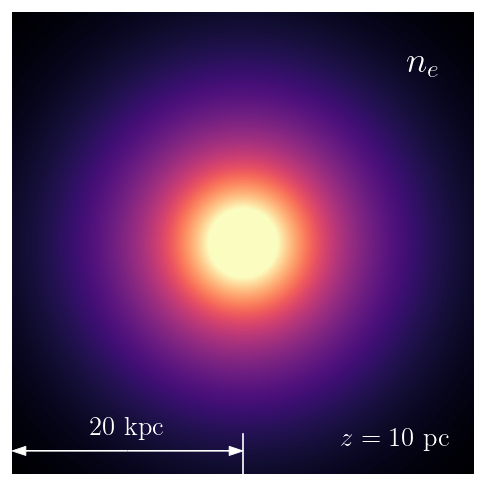

In [4]:
fig, ax = plt.subplots(figsize=(5, 5))

func = n_e_SRWE
smax = 20 # [kpc]
h_zval = 0.01 # [kpc]
npix = 300
    
x_s = jnp.linspace(-smax, smax, npix)
y_s = jnp.linspace(-smax, smax, npix)
x_ss, y_ss = jnp.meshgrid(x_s, y_s)

x_in = jnp.reshape(x_ss, (npix*npix,))
y_in = jnp.reshape(y_ss, (npix*npix,))
stz_in = jnp.stack([jnp.sqrt(x_in**2+y_in**2),
                    jnp.arctan2(y_in, x_in),
                    jnp.full_like(x_in, h_zval)], axis=-1)
hslice = jnp.reshape(func(stz_in), (npix, npix))

vmax = jnp.max(hslice[hslice<jnp.inf])
vmin = jnp.min(hslice[hslice<jnp.inf])
im = ax.imshow(jnp.flipud(hslice), extent=(-smax, smax, -smax, smax), cmap='magma')
ax.text(17, 17, r'$n_e$', color='w', fontsize=22, ha='right', va='top')
ax.text(18, -18, r'$z=10~$pc', color='w', fontsize=16, ha='right', va='bottom')
ax.axis('off')
# ax.set_xticks([-20, -10, 0, 10, 20])
# ax.set_yticks([-20, -10, 0, 10, 20])
# ax.set(xlabel='[kpc]', ylabel='[kpc]')

ax.arrow(-10, -18, 10,  0, fc='w', ec='w', length_includes_head=True, head_width=0.8, lw=0.5)
ax.arrow(-10, -18, -10, 0, fc='w', ec='w', length_includes_head=True, head_width=0.8, lw=0.5)
ax.plot([0, 0], [-20, -16.5], color='w', lw=1)
ax.text(-10, -16, '20 kpc', color='w', ha='center', va='center', fontsize=16)

fig.savefig("plots/gsr/ne.pdf")

### 3. $I$

In [3]:
scheme = 'JF'
if scheme == 'AH':
    B_func = B_SRWE_AH
    n_e_func = n_e_SRWE
elif scheme == 'BH':
    B_func = B_SRWE_BH
    n_e_func = n_e_SRWE
elif scheme == 'JF':
    B_func = B_JF
    n_e_func = n_e_SRWE
else:
    raise ValueError(f'Unknown scheme.')
    
def power_density(stz):
    """Synchrotron intensity taking into account the direction of the B field.
    p [unnormalized] as a function of stz ([kpc], [rad], [kpc]). Vectorized manually;
    batch dimension is the first.
    """
    B_vxyz = vstz2vxyz_stz(B_func(stz), stz)
    LOS_vxyz = LOS_direction(GCxyz_stz(stz))
    B_perp_vxyz = jnp.linalg.norm(cross_product(B_vxyz, LOS_vxyz), axis=-1)
    return n_e_func(stz) * B_perp_vxyz**spec_ind_alpha
    
@jit
@vmap
def I_src(lb):
    l, b = lb
    lbd = jnp.stack([jnp.full_like(intg_d_s, l),
                     jnp.full_like(intg_d_s, b),
                     intg_d_s], axis=-1)
    I_integrands = power_density(GCstz(lbd))
    return jnp.trapz(I_integrands, intg_d_s)

In [8]:
nside = 256
l, b = hp.pixelfunc.pix2ang(nside, np.arange(hp.nside2npix(nside)), lonlat=True)
l = jnp.deg2rad(l)
b = jnp.deg2rad(b)
I_map = I_src(jnp.stack([l, b], axis=-1))

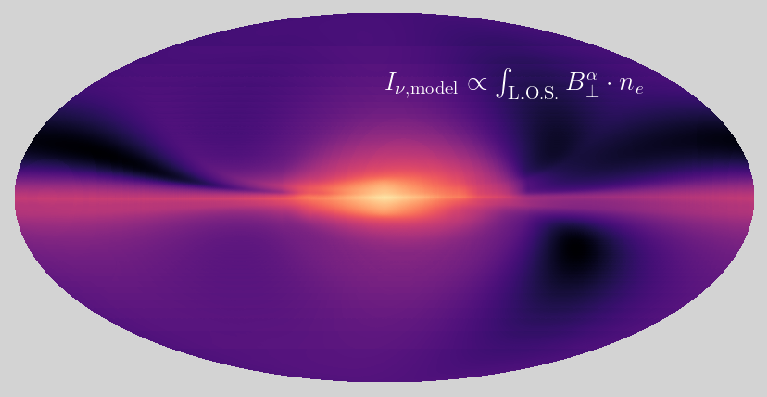

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.sca(ax)
plt.gcf().patch.set_facecolor('lightgray')
hp.mollview(I_map, cmap='magma', hold=True, norm='log', title='', cbar=False, max=200, bgcolor='lightgray')
plt.text(0.85, 0.75, r'$I_{\nu,\mathrm{model}}\propto \int_\mathrm{L.O.S.} B_\perp^\alpha\cdot n_e$', color='w', fontsize=16,
         transform=ax.transAxes, ha='right', va='center')
fig.savefig('plots/gsr/I.pdf', bbox_inches='tight')

### 4. Haslam

Text(0.75, 0.75, '$I_{\\nu,\\mathrm{Haslam}}$')

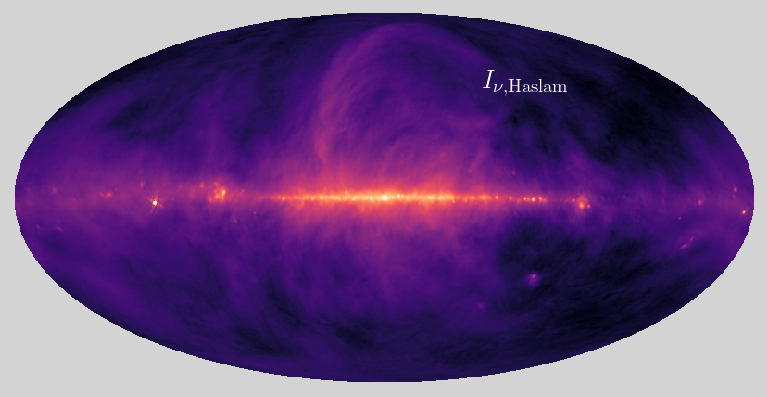

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
haslam_dsds_map_hp = hp.read_map('../data/gsr/haslam408_dsds_Remazeilles2014.fits')
plt.sca(ax)
plt.gcf().patch.set_facecolor('lightgray')
hp.mollview(haslam_dsds_map_hp, cmap='magma', hold=True, norm='log', title='', cbar=False, max=30*np.median(haslam_dsds_map_hp), bgcolor='lightgray')
plt.text(0.75, 0.75, r'$I_{\nu,\mathrm{Haslam}}$', color='w', fontsize=16,
        transform=ax.transAxes, ha='right', va='center')
#fig.savefig('plots/gsr/haslam.pdf', bbox_inches='tight')

### 5. ratio

In [34]:
I_map = hp.ud_grade(I_map, nside_out=512)
I_map = np.array(I_map) / np.mean(np.clip(I_map, None, 100.)) * np.mean(haslam_dsds_map_hp)

AttributeError: 'tuple' object has no attribute 'size'

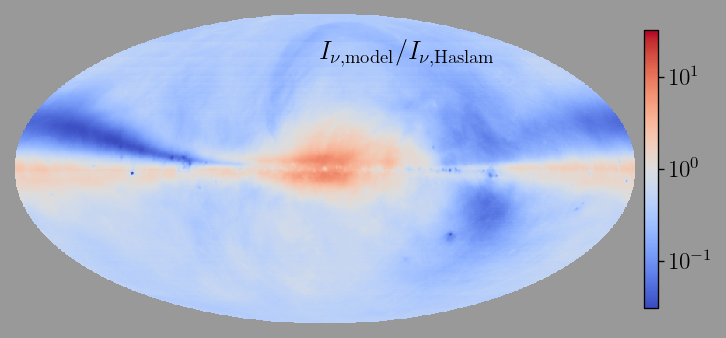

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.sca(ax)
plt.gcf().patch.set_facecolor(cms['binary'](0.4))
hp.mollview(-np.log10(haslam_dsds_map_hp/np.array(I_map)), cmap='coolwarm', hold=True, title='', cbar=False, min=-1.5, max=1.5, bgcolor=cms['binary'](0.4))
plt.text(0.65, 0.75, r'$I_{\nu,\mathrm{model}}/I_{\nu,\mathrm{Haslam}}$', color='k', fontsize=16,
         transform=ax.transAxes, ha='right', va='center')
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax, orientation='vertical', aspect=20, pad=0.01, ticks=[-1, 0, 1], shrink=0.6)
cbar.ax.set_yticklabels([r'$10^{-1}$', r'$10^0$', r'$10^{1}$'])
fig.savefig('plots/gsr/ratio.pdf', bbox_inches=(8, 4.1333))
plt.show()

### 6. 3D

In [51]:
scheme = 'JF'
if scheme == 'AH':
    B_func = B_SRWE_AH
    n_e_func = n_e_SRWE
elif scheme == 'BH':
    B_func = B_SRWE_BH
    n_e_func = n_e_SRWE
elif scheme == 'JF':
    B_func = B_JF
    n_e_func = n_e_SRWE
else:
    raise ValueError(f'Unknown scheme.')

In [ ]:
li_s = np.linspace(0, 360, 100)
bi_s = np.linspace(-90, 90, 100)
li_grid, bi_grid = jnp.meshgrid(li_s, bi_s)
ratio_map_hp = haslam_dsds_map_hp/np.array(I_map)
ratio_map_grid = jnp.array(hp.pixelfunc.get_interp_val(ratio_map_hp, li_grid, bi_grid, lonlat=True))

In [ ]:
def interp2d(f, x0, x1, xv):
    """Interpolates f(x) at values in xvs. Does not do bound checks.
    f : (n>=2 D) array of function value.
    x0 : 1D array of input value, corresponding to first dimension of f.
    x1 : 1D array of input value, corresponding to second dimension of f.
    xv : [x0, x1] values to interpolate.
    """
    xv0, xv1 = xv
    
    li0 = jnp.searchsorted(x0, xv0) - 1
    lx0 = x0[li0]
    rx0 = x0[li0+1]
    p0 = (xv0-lx0) / (rx0-lx0)
    
    li1 = jnp.searchsorted(x1, xv1) - 1
    lx1 = x1[li1]
    rx1 = x1[li1+1]
    p1 = (xv1-lx1) / (rx1-lx1)
    
    fll = f[li0,li1]
    return fll + (f[li0+1,li1]-fll)*p0 + (f[li0,li1+1]-fll)*p1

interp2d_vmap = jit(vmap(interp2d, in_axes=(None, None, None, 0)))

In [ ]:
def ratio(stz):
    lbd = Glbd(stz)
    lb = lbd[:, :2]
    return interp2d_vmap(ratio_map_grid, bi_s, li_s, lb)

In [24]:
ratio(jnp.array([[1., 0., 3.]]))

Array([5.949082], dtype=float32)

In [53]:
view_sz = jnp.array([40, 20]) # assume t = PI

def Vstz(lbd):
    """stz from viewer's lbd."""
    vs, vz = view_sz
    v_GC_d = jnp.sqrt(vs**2 + vz**2)
    l, b, d = lbd[:,0], lbd[:,1], lbd[:,2]
    rx = d * jnp.cos(b) * jnp.cos(l) - v_GC_d # rotated x
    ry = d * jnp.cos(b) * jnp.sin(l) # rotated y = original y
    rz = d * jnp.sin(b) # rotated z

    r_angle = jnp.arctan(vz/vs)
    x = rx * jnp.cos(r_angle) + rz * jnp.sin(r_angle)
    y = ry
    z = - rx * jnp.sin(r_angle) + rz * jnp.cos(r_angle)
    
    return jnp.stack([jnp.sqrt(x**2 + y**2),
                      jnp.arctan2(y, x),
                      z], axis=-1)

def VLOS_direction(xyz):
    """Viewer's line of sight direction (radially outward) of xyz coordinates."""
    x, y, z = xyz[:,0], xyz[:,1], xyz[:,2]
    vs, vz = view_sz
    return unit_vec(jnp.stack([x+vs, y, z-vz], axis=-1))

def Vpd(stz):
    B_vxyz = vstz2vxyz_stz(B_func(stz), stz)
    VLOS_vxyz = VLOS_direction(GCxyz_stz(stz))
    B_perp_vxyz = jnp.linalg.norm(cross_product(B_vxyz, VLOS_vxyz), axis=-1)
    return n_e_func(stz) * B_perp_vxyz**spec_ind_alpha * ratio(stz)
    
@jit
@vmap
def VI(lb):
    l, b = lb
    lbd = jnp.stack([jnp.full_like(intg_d_s, l),
                     jnp.full_like(intg_d_s, b),
                     intg_d_s], axis=-1)
    I_integrands = Vpd(Vstz(lbd))
    return jnp.trapz(I_integrands, intg_d_s)

In [ ]:
npix = 300
l_s = np.deg2rad(np.linspace(-50, 50, npix))
b_s = np.deg2rad(np.linspace(-30, 21.666, npix))
l_grid, b_grid = jnp.meshgrid(l_s, b_s)
lb_flat = jnp.stack([l_grid.ravel(), b_grid.ravel()], axis=-1)
VI_map = VI(lb_flat).reshape((npix, npix))

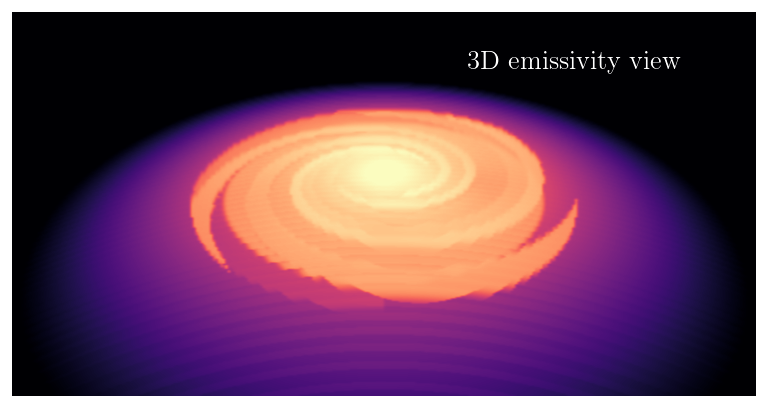

In [31]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.imshow(np.flip(np.log10(np.clip(VI_map, 1e-10, None))), cmap='magma', extent=(-50, 50, -30, 21.666),
          interpolation='bicubic', vmax=2, vmin=-10)
ax.axis('off')
ax.text(0.9, 0.9, '3D emissivity view', color='w', transform=ax.transAxes,
        ha='right', va='top', fontsize=16)
fig.savefig('plots/gsr/VI.pdf')

In [32]:
nside = 256
l, b = hp.pixelfunc.pix2ang(nside, np.arange(hp.nside2npix(nside)), lonlat=True)
l = jnp.deg2rad(l)
b = jnp.deg2rad(b)
VI_map = VI(jnp.stack([l, b], axis=-1))

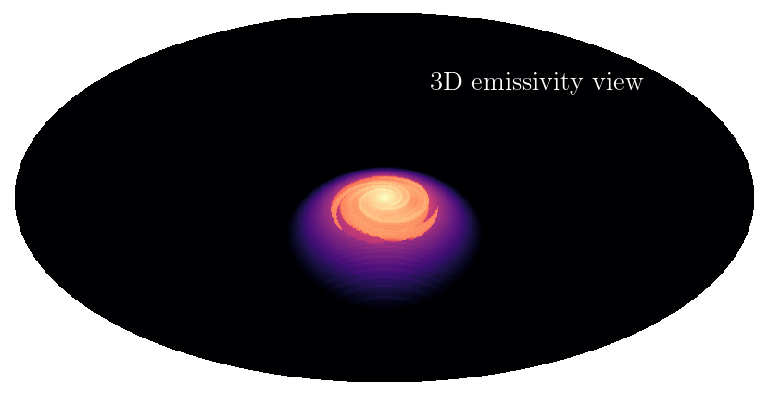

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.sca(ax)
hp.mollview(np.clip(VI_map, 1e-10, None), cmap='magma', hold=True, norm='log', title='', cbar=False, min=1e-10)
plt.text(0.85, 0.75, r'3D emissivity view', color='w', fontsize=16,
         transform=ax.transAxes, ha='right', va='center')
fig.savefig('plots/gsr/VI_hp.pdf')
plt.show()